# Transfer learning 
In this notebook, we will use the follwoing tools:
- Tensorflow (using tensorflow.keras to make life easier)
- classification-models (a library of pre-trained models)

Our task is to transfer a model from classifying the imagenet dataset to a much smaller dataset of picturs of bees and ants. The dataset is called hymenoptera, and comes from one of the pytorch examples. We will be replicating the pytorch example quite closely, but in keras.

We are using transfer learning because we expect it will do much better on our small dataset than starting from scratch. Imagenet has 1.3 million examples across 1000 classes; our dataset has 120 examples across 2 classes. 120 images is a very small number when trying to train a CNN.


Our task is to take a model from the classification zoo and use a technique called transfer learning to apply it to the hymenoptera dataset.

We'll break it down into several steps.

First, lets download the dataset and unzip it

In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -qf hymenoptera_data.zip

## Install some packages if we don't already have them
!pip3 install git+https://github.com/qubvel/classification_models.git

--2020-02-25 13:10:47--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.78.101, 13.224.78.23, 13.224.78.61, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.78.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.5’

hymenoptera_data.zi 100%[===================>]  45.10M  11.2MB/s    in 4.0s    

2020-02-25 13:10:51 (11.2 MB/s) - ‘hymenoptera_data.zip.5’ saved [47286322/47286322]



If we have a look, we should now have a folder called 'hymenoptera' in which we have sub-folders called 'train' and 'validation'. 

This is a very important step which has already been done for us. It is *imperative* that you split your dataset before you do anything. You should take out a portion of your data and leave it alone until you've finished training your models. This is the test set, sometimes called the validation set.

Splitting the dataset has already been done for us here, so we don't need to worry about it.

Let's have a look at one of the images in the training set. To load it, we will import imread from skimage, and to show it we will use matplotlib.

Ant image shape: (333, 500, 3)
Bee image shape: (333, 500, 3)
min & max in ant image: (0, 255)


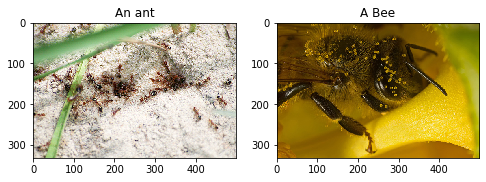

In [3]:
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
anAnt = imread("./hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg")
aBee = imread("./hymenoptera_data/train/bees/1092977343_cb42b38d62.jpg")

fig, axes = plt.subplots(1,2, figsize=(8,10))
axes[0].imshow(anAnt)
axes[0].set_title("An ant")

axes[1].imshow(aBee)
axes[1].set_title("A Bee");

print(f"Ant image shape: {anAnt.shape}")
print(f"Bee image shape: {aBee.shape}")
print(f"min & max in ant image: {anAnt.min(), anAnt.max()}")

As you can see, the images are colour, having three channels (RGB), they are also unsigned 8 bit integers (range 0-255). These two are 333x500 pixels (hxw), but having looked through the dataset, not all on them are this size: we will have to deal with that later because a neural network expects images of a constant size during training.

Have a look for other image names by running the cell below (it just lists the images in the training data folders). If you want, you can visualise some different images to see what we will be training on.

Now we are ready to make a start preparing to train a neural network. First, we must set up some infrastructure to load and transform the images.

Fortunately, we don't have to do much of this ourselves. Keras provides a class that can apply transformations automatically, including some that artificially extend the dataset, called data augmentation. To begin with, we will just resize and crop the images to the size expected by the CNN, which is 224x224 pixels.

We also need to do some normalisation on the images. This functionality is provided by the same library we will use to load a pretrained model, but we will have to add it to the keras data generator as an extra preprocessing function. Therefore, in the next cell we will:

- Load ImageDataGenerator, which does the image loading and most of the transformations
- Create a custom data generator wrapper to crop images to 224x224
- Load the pretrained model and its preprocessing function
- Put everything together to create our image loading pipeline

For now, we will leave the network alone and build it later, we mainly just want its preprocessing function right now. We are going to use a small model called ResNet18, it should be very quick to train, and give pretty good results.

In [3]:
!ls -lh ./hymenoptera_data/train/bees 

total 14M
-rw-r--r-- 1 andrew andrew 116K Mar 13  2017 1092977343_cb42b38d62.jpg
-rw-r--r-- 1 andrew andrew  98K Mar 13  2017 1093831624_fb5fbe2308.jpg
-rw-r--r-- 1 andrew andrew 168K Mar 13  2017 1097045929_1753d1c765.jpg
-rw-r--r-- 1 andrew andrew 108K Mar 13  2017 1232245714_f862fbe385.jpg
-rw-r--r-- 1 andrew andrew 182K Mar 13  2017 129236073_0985e91c7d.jpg
-rw-r--r-- 1 andrew andrew  78K Mar 13  2017 1295655112_7813f37d21.jpg
-rw-r--r-- 1 andrew andrew 124K Mar 13  2017 132511197_0b86ad0fff.jpg
-rw-r--r-- 1 andrew andrew  99K Mar 13  2017 132826773_dbbcb117b9.jpg
-rw-r--r-- 1 andrew andrew 120K Mar 13  2017 150013791_969d9a968b.jpg
-rw-r--r-- 1 andrew andrew  71K Mar 13  2017 1508176360_2972117c9d.jpg
-rw-r--r-- 1 andrew andrew 101K Mar 13  2017 154600396_53e1252e52.jpg
-rw-r--r-- 1 andrew andrew  72K Mar 13  2017 16838648_415acd9e3f.jpg
-rw-r--r-- 1 andrew andrew 107K Mar 13  2017 1691282715_0addfdf5e8.jpg
-rw-r--r-- 1 andrew andrew  49K Mar 13  2017 17209602_fe5a5a746f.jpg
-rw-r

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator ## Does most of the work for us
from classification_models.tfkeras import Classifiers
from functools import partial
import numpy as np

dataDirectory = "./hymenoptera_data/train/"

def centreCrop224(image):
    """
    Centre crops an image to 224x224. Expects the image to be 256x256 coming in.
    """
    if image.shape[1:] != (256,256,3):
        raise RuntimeError("Image is not reshaped")
    return image[:,16:-16, 16:-16, :]

def chainFunctions(image, funclist=[]):
    for func in funclist:
        image = func(image)
    return image

def cropGenerator(batchGen):
    """
    Wrap the default generator, and do centre cropping
    """
    while True:
        batch_x, batch_y = next(batchGen)
        yield(centreCrop224(batch_x), batch_y)


## quickly test the centre cropping function
test = np.zeros((1,256,256,3))
test_cropped = centreCrop224(test)
assert(test_cropped.shape == (1,224,224,3))

## now load the pretrained model class, and its preprocessing function. NB: don't create a model yet
ResNet18, preprocess_input_rn18 = Classifiers.get("resnet18")

## Now make a list of the preprocessing functions we want to apply, in order
preprocessing = [centreCrop224, preprocess_input_rn18]

## Now construct the generator object. Note that it doesn't yet link up with the data!
dataGenerator = ImageDataGenerator(validation_split=0.1, 
                                   preprocessing_function=preprocess_input_rn18, 
                                   horizontal_flip=True, 
                                   rotation_range=15)

## Link the generator to the data
batch_size = 16
trainGen = cropGenerator(dataGenerator.flow_from_directory(dataDirectory, batch_size=batch_size, subset="training"))
valGen = cropGenerator(dataGenerator.flow_from_directory(dataDirectory, batch_size=batch_size, subset="validation"))

Found 220 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


A quick explanation of what is going on with the partial stuff here:

Partial allows us to half specify in advance some arguments in a function call. In this case, the keras ImageDataGenerator class requires the preprocessing function to accept only one argument (the image), but we need to be able to change our preprocessing functions. By using a partial function, we can have our cake and eat it: we get to have a function that takes only one argument, but in which we can change the list of preprocessing functions!

You may have spotted that we have some stuff in the data generator definition about 'validation' and 'validation splits': didn't we already do this?

This is an example of naming conventions not being agreed on yet. The validation data in the ./.../validation/... directory is also referred to as a test set. The test set is the one we must leave alone until the very end. A validation set (in keras terms) is a dataset we use along the way to steer the training of a network. In this case, we split off a little bit of the training data and use that to guide the training of the network as we go along; this helps stop us from ending up in a local minimum where the training accuracy is very good, but the network doesn't generalise and can't classify the test dataset.

With the data generator pipelines all set up, lets generate some batches and see what our data looks like!

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


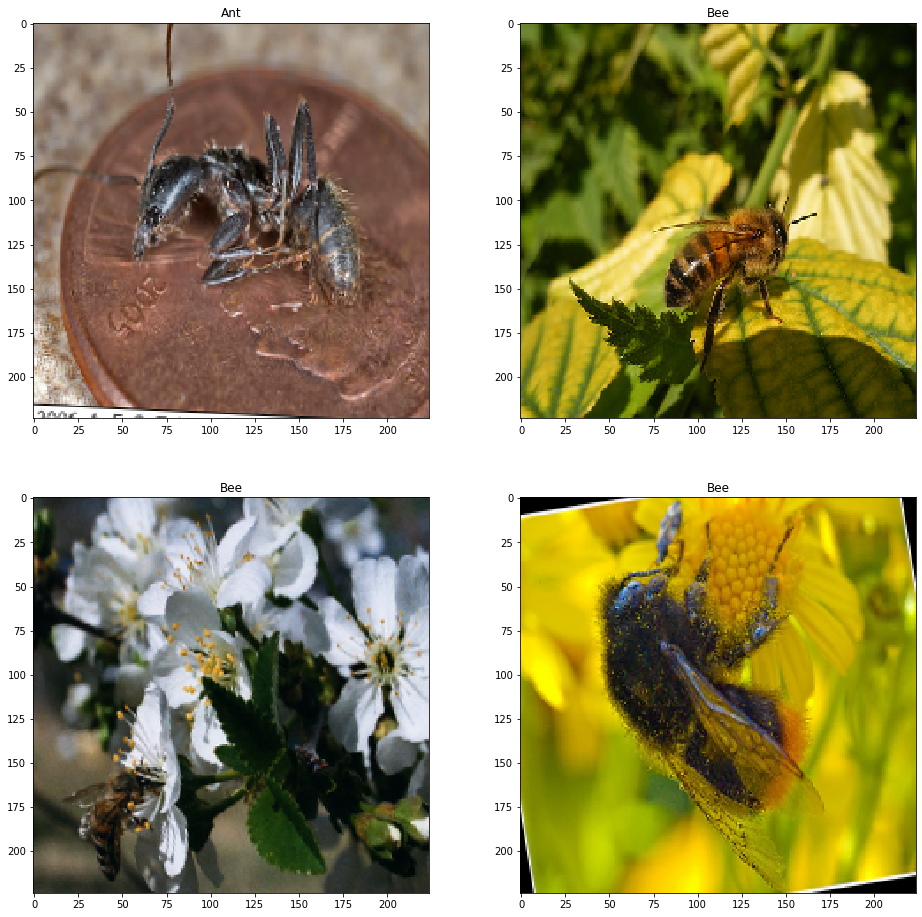

In [5]:
## handy label to name decoder
labelDecode = {0:"Ant", 1:"Bee"}

## generate a batch
aBatchImages, aBatchLabels = next(trainGen)
print(aBatchLabels)
## Show some images!
fig, axes = plt.subplots(2,2, figsize=(16,16))
axes[0,0].imshow(aBatchImages[0,...].astype(np.uint8))
axes[0,0].set_title(labelDecode[np.argmax(aBatchLabels[0])])

axes[0,1].imshow(aBatchImages[1,...].astype(np.uint8))
axes[0,1].set_title(labelDecode[np.argmax(aBatchLabels[1])])

axes[1,0].imshow(aBatchImages[2,...].astype(np.uint8))
axes[1,0].set_title(labelDecode[np.argmax(aBatchLabels[2])])

axes[1,1].imshow(aBatchImages[3,...].astype(np.uint8))
axes[1,1].set_title(labelDecode[np.argmax(aBatchLabels[3])]);

Now we've got the images loading and being correctly preprocessed, we can turn our attention to constructing a network.

Remember that we are using a pretrained model, whose weights come from classifying images into one of 1000 classes. Those weights are coefficients in kernels that are used to do convolutions on the image and extract features. For a good explanation of what is going on in convolutions, have a look at the materials [here](http://www.google.co.uk). The convolutional parts of a CNN are performing 'feature extraction'. Feature extraction is the process where we take a 2D image and find a representation of it in a higher dimensional space such that we can classify images by finding the difference between them in that high dimensional space.

In a CNN, the usual way this works is with one or two fully connected layers in the classifier, which take features from the convolutional part. We will use this method, though it is also possible to extract features with a CNN and do classification with a 'classical' algortihm such as a Random Forest classifier.

For now, we need to make the following modifications to our network:

- Make sure the input size is correct (224x224x3)
- Change the 'top' (or 'classifier') of the network to classify into two classes
- Link up the main bit of the network with the classifier.

We will try two approaches to transfer learn:

1. We will use the resnet18 network to extract features, which we will then use to classify the images
2. We will use the resnet18 features as the starting point to train our own feature extraction and classification in one.

When using the network for feature extraction, we want to 'freeze' the convolutional layers, whereas when training our own specialised feature extraction, we want to train all the layers in the network. Here we will write a function that allows us to create models with either specification, and the correct number of classes.



In [6]:
from classification_models.tfkeras import Classifiers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

## Create the class definition for ResNet18
ResNet18, preprocess_input_rn18 = Classifiers.get("resnet18")


def resnetHymenoptra(input_shape=(224,224,3), classes=2, freezeLayers=True, pretrained=True):
    """
    Build a model based on resnet 18 with pretrained weights. Optionally freeze the feature extraction layers
    """
    if pretrained:
        resNetBase = ResNet18(input_shape=input_shape, weights='imagenet', include_top=False)
    else:
        resNetBase = ResNet18(input_shape=input_shape, weights=None, include_top=False)

    if freezeLayers:
        for layer in resNetBase.layers:
            layer.trainable = False
    ## construct the last bit of the model
    x = resNetBase.output
    x = GlobalAveragePooling2D()(x)
    
    prediction = Dense(classes, activation='softmax')(x)
    
    ## Now create the hymenoptera model
    rnh_model = Model(inputs=resNetBase.inputs, outputs=prediction)
    return rnh_model
    

Now we can create the model and get a summary of it. Let's start by getting a model with frozen feature extraction layers

In [7]:
rnh_frozen = resnetHymenoptra(input_shape=(224,224,3), classes=2, freezeLayers=True, pretrained=True)

print(rnh_frozen.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
___________

You should see a huge output listing. This is the resnet18 architecture. It is made out of convolutional layers (Conv2D), batch normalisation layers (BatchNormalization), activations, padding, pooling, addition and one dense layer.

At the bottom, you can see how many parameters there are in the model. When I run this, I see about 11 million in total, with 1026 being trainable. This is because we froze the entire feature extraction part of the network.

Now we can move on to training the model.



To train the model, we need to get a couple of things ready. We need to know how good the model is at classifying images, and we need a way to improve the model's perfromance.

The first is solved by using a loss function (sometimes called a cost function). A loss function tells us how close the model's prediction is to the observed labels on our dataset. There are a lot of losses, but the most appropriate in our case is either the binary_crossentropy loss, or the categorical_crossentropy loss. These two losses tell us how similar the distribution of labels given by the model and those in the observations are. The ideal value for both is zero, so we are looking for the loss value to go down and approach zero. 

Our classification problem is binary (the picture is either a bee or an ant), but because of the way we set up our generator (see the documentation (here)[https://keras.io/preprocessing/image/#imagedatagenerator-class] to see what I mean) we will start with the categorical crossentropy loss. We can try changing this part of the training later to see if we get better performance.

The second part, in which we get the model to improve, is handled by an optimizer. Optimizers are a complex field where much research is still being done. Fortunately, keras provides some very good optimizers out of the box. All optimizers try to figure out the best network parameters by looking at the gradient of the loss function with respect to those parameters. This is an 11 million dimensional partial differential equation in our case, so it is very much not trivial! 

Optimizers generally work on batches of data drawn from the whole dataset. This means that the gradient is approximage at every evaluation, so we see some noise in the training performance. Optimizers also have a learning rate parameter, which controls how quickly they step along the direction of decreasing gradient. this can be very important, as steps too large can end up oscillating around a minimum rather than converging to it.

The choice of optimizer and its settings can have a profound effect on how well a network trains and generalises, so it is a good idea to try a few. This process is called hyperparameter tuning.

### Hyperparameters
A hyperparameter is something which indirectly influences the performance of a network. For example, the choice of optimizer may have an impact on how well a network generalises to an unseen test set. There are many hyperparameters, some of which are more subtle than others. Here are a few we can try playing with here:

- Batch size. I set it to 16 where we created the image generators. You could go higher or lower.
- Learning rate. I have used a default of 1E-3. You could try higher or lower.
- Optimizer. I chose stochastic gradient descent with momentum. There are a lot of optimizers in keras whose documentation you can find here: https://keras.io/optimizers/. You can also try changing the momentum value.
- Data augmentations. We haven't done any, so anythig you add can change the performance drastically.
- Loss function. We're using categorical crossentrpy
- Anything else you think might affect the model!

Before trying anything fancy, let's just see if we can train the classifier using the feature extraction from resnet 18. 

### Training 
To run the training in keras is very simple. We:

1. Compile the model. This links up the model, loss function and optimizer (and any metrics we want)
2. Use the model.fit_generator function with our image data generators from earlier

In [8]:
## first, compile the model
from tensorflow.keras import optimizers

## define the optimizer
opt = optimizers.SGD(lr=1E-3, momentum=0.9)

rnh_frozen.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])


In [12]:
## Now fit it

steps_train = 2*220 // batch_size
steps_val = 2*24 // batch_size

frozen_fit_history = rnh_frozen.fit_generator(trainGen,
                                              verbose=1,
                                              steps_per_epoch=steps_train, 
                                              epochs=5, 
                                              validation_data=valGen, 
                                              validation_steps=steps_val
                                             )

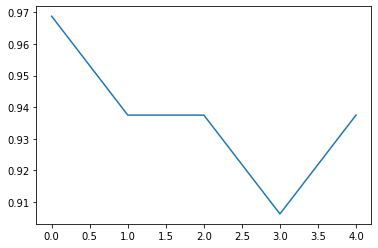

In [13]:
plt.plot(frozen_fit_history.history['val_acc'])

For me, I get something like 87% accuracy in just a few epochs of training, which is great!

Now though, we want to see if we can push the accuracy higher by finetuning the convolution parts of the network. To do this, lets create a new model, but with the pretrained weights un-frozen. We will then compile with the same options, but a much lower learning rate, and try fitting that model

In [14]:
rnh_defrosted =  resnetHymenoptra(input_shape=(224,224,3), classes=2, freezeLayers=False, pretrained=True)

print(rnh_defrosted.summary())

opt2 = optimizers.SGD(lr=1e-4, momentum=0.9, nesterov=False)
rnh_defrosted.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

steps_train = 220 // batch_size
steps_val = 24 // batch_size

unfrozen_fit_history = rnh_defrosted.fit_generator(trainGen, 
                                              steps_per_epoch=steps_train, 
                                              epochs=25, 
                                              validation_data=valGen, 
                                              validation_steps=steps_val)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_18[0][0]          
____________________________________________________________________________________________

Epoch 1/25
13/13 [==============================] - 3s 263ms/step - loss: 0.8444 - acc: 0.5294 - val_loss: 0.4141 - val_acc: 0.8750
Epoch 2/25
13/13 [==============================] - 1s 93ms/step - loss: 0.4278 - acc: 0.8088 - val_loss: 0.1239 - val_acc: 1.0000
Epoch 3/25
13/13 [==============================] - 2s 150ms/step - loss: 0.2724 - acc: 0.8922 - val_loss: 0.7326 - val_acc: 0.8750
Epoch 4/25
13/13 [==============================] - 2s 147ms/step - loss: 0.1940 - acc: 0.9118 - val_loss: 0.0411 - val_acc: 1.0000
Epoch 5/25
13/13 [==============================] - 2s 148ms/step - loss: 0.1687 - acc: 0.9510 - val_loss: 0.0190 - val_acc: 1.0000
Epoch 6/25
13/13 [==============================] - 2s 147ms/step - loss: 0.1198 - acc: 0.9608 - val_loss: 0.0279 - val_acc: 1.0000
Epoch 7/25
13/13 [==============================] - 2s 147ms/step - loss: 0.0987 - acc: 0.9657 - val_loss: 0.6384 - val_acc: 0.7500
Epoch 8/25
13/13 [==============================] - 2s 152ms/step - loss: 0.0

At this point, we can test our model on the test set. To do this, we create another image data generator that loads the test set. It will have exactly the same parameters as the training and validation generators

In [71]:
testDirectory = "./hymenoptera_data/val/"
testGenBase = ImageDataGenerator(preprocessing_function=preprocess_input_rn18) ## no augmentation for now
testGen = cropGenerator(testGenBase.flow_from_directory(testDirectory, batch_size=1))

## model shootout
print(rnh_frozen.evaluate_generator(testGen, steps=153))
print(rnh_defrosted.evaluate_generator(testGen, steps=153))


Found 153 images belonging to 2 classes.
[0.23982579379401975, 0.9411765]
[0.24394089377644526, 0.9281046]
